In [ ]:
!pip install git+https://github.com/kornia/kornia@align_corners=False
!pip install pytorch_metric_learning

In [2]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import random
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from fastai2.basics import *
from fastcore import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastprogress import fastprogress
from fastai2.callback.mixup import *
from fastscript import *
import torchvision as tv
import kornia as K

def imshow_torch(tensor, *kwargs):
    plt.figure()
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

In [31]:
train_ds_name = 'liberty'
val_ds_name = 'notredame'
val_ds_name2 = 'yosemite'

ds_root = '/home/old-ufo/storage/datasets/UBC-Phototour-Patches-Torch'

First, we will define modified dataset to match HardNet implementation.
Specifically, it generates pairs of the same-class images for the batch.

In [4]:
class PairPhotoTour(tv.datasets.PhotoTour):
    """
    From the PhotoTour Dataset it generates pairs of same class in a batch
    Based on code from https://github.com/vbalnt/tfeat
    """
    def __init__(self,
                 train_mode=True, # We need different behavoir for train and test mode
                 bs = 1024, #batch size. There will be only 2 samples of same class in the batch.
                 n_pairs = 1024*5000, #It is simple to have n_pairs to be divisible by bs
                 *arg, **kw):
        super(PairPhotoTour, self).__init__(*arg, **kw)
        self.train_mode = train_mode
        self.n_pairs = n_pairs
        self.bs = bs
        # Dict: indexes of the class samples by class label
        self.indices_dict = self.create_indices(self.labels.numpy())
        if self.train_mode:
            self.generate_pairs()
        return
    
    def create_indices(self, labels):
        inds = dict()
        for idx, ind in enumerate(labels):
            if ind not in inds:
                inds[ind] = []
            inds[ind].append(idx)
        return inds

    def generate_pairs(self):
        labels = self.labels
        num_pairs = self.n_pairs
        self.pairs = []
        indices_dict = self.indices_dict
        classes = np.unique(self.labels.numpy())
        n_classes = classes.shape[0]
        num_epochs = num_pairs // n_classes + 1
        print('Generating {} pairs for training'.format(self.n_pairs))
        for ep in progress_bar(range(num_epochs)):
            classes_perm = np.random.permutation(classes)
            for c in classes_perm:
                samples_in_class = indices_dict[c]
                if len(samples_in_class) > 2:
                    random.shuffle(samples_in_class)
                self.pairs.append([*samples_in_class[:2], c])
        self.pairs = torch.LongTensor(self.pairs)[:num_pairs]
        return 

    def __getitem__(self, index):
        if not self.train_mode:
            m = self.matches[index]
            img1 = self.data[m[0]]
            img2 = self.data[m[1]]
            # Output: two concatenated  an match/non-match label, as definited in Brown at.al 2010
            return img1.unsqueeze(0), img2.unsqueeze(0), m[2] 
        t = self.pairs[index]
        img_a, img_p, label = self.data[t[0]], self.data[t[1]], t[2]
        # Output: two concatenated images of the same class and class label
        return img_a.unsqueeze(0), img_p.unsqueeze(0), label

    def __len__(self):
        if self.train_mode:
            return self.pairs.size(0)
        else:
            return self.matches.size(0)

We will do augmentation on GPU with [kornia](https://github.com/kornia/kornia)

In [5]:
orig_size = 64
out_size = 32
sigma = orig_size / (2.*out_size)

train_aug = nn.Sequential( 
    K.filters.GaussianBlur2d((7,7),(0.6,  0.6)), # Blur for proper downscale
    torch.nn.ReplicationPad2d(8), # otherwise small black corners appear
    K.augmentation.RandomAffine(degrees=(-5.0, 5.0),
                                scale=(0.9, 1.0),
                                shear=(5.0, 5.0),
                                translate=(0.03, 0.03)),
    K.augmentation.CenterCrop(orig_size),
    K.Resize((out_size,out_size)))

test_aug = nn.Sequential( 
    K.filters.GaussianBlur2d((7,7),(0.6,  0.6)), # Blur for proper downscale
    K.Resize((out_size,out_size)))


In [6]:
from fastai2  import *
# We need to transform all images
class TupleAug(ItemTransform):
    def __init__(self, tfm):
        self.tfm = tfm
    def encodes(self, o): 
        out = []
        with torch.no_grad():
            for i,oi in enumerate(o):
                if i < len(o) - 1:
                    out.append(self.tfm(oi.float()))
                else:
                    out.append(oi)
        return out
class ReshapeTupleToBatch(ItemTransform):
    def encodes(self, o): 
        return torch.cat(o[:-1],dim=0), o[-1].repeat(len(o)-1)    

In [7]:
class BatchRandomFlip(ItemTransform):
    def encodes(self, o): 
        mask = torch.randint_like(o[-1], 0,2) > 0
        out = [] 
        with torch.no_grad():
            for oi in o[:-1]:
                out.append(oi)
                out[-1].masked_scatter_(mask.view(-1,1,1,1), oi.flip(3))
            mask2 = torch.randint_like(o[-1], 0,2) > 0
            for i, oi in enumerate(out):
                out[i].masked_scatter_(mask2.view(-1,1,1,1), oi[mask2].flip(3))
        out.append(o[-1])
        return out

Lets create data loaders

Generating 5120000 pairs for training


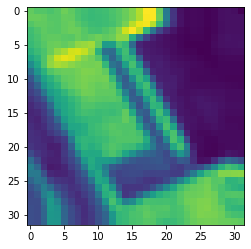

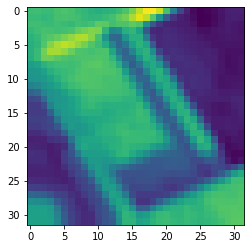

In [32]:
BS = 1024
TEST_BS = 128
N_WORKERS = 4

ds_train = PairPhotoTour(root=ds_root,
                              name=train_ds_name,
                              bs=BS,
                              n_pairs=5000*BS,  
                              train_mode=True)

ds_val = PairPhotoTour(root=ds_root,
                      name=val_ds_name,
                      train_mode=False)
ds_val2 = PairPhotoTour(root=ds_root,
                      name=val_ds_name2,
                      train_mode=False)


dl_train = TfmdDL(ds_train,
                 device=torch.device('cuda:0'),
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(train_aug), # augmening both patches in pair
                              BatchRandomFlip,  # random flip
                              ReshapeTupleToBatch], #two patches -> single tensor
                 bs=BS, num_workers=N_WORKERS)

dl_val = TfmdDL(ds_val,
                 device=torch.device('cuda:0'),
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(test_aug), ReshapeTupleToBatch],
                 bs=TEST_BS, num_workers=N_WORKERS)

dl_val2 = TfmdDL(ds_val2,
                 device=torch.device('cuda:0'),
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(test_aug), ReshapeTupleToBatch],
                 bs=TEST_BS, num_workers=N_WORKERS)

patches, labels  = dl_train.one_batch()

imshow_torch(patches[0])
imshow_torch(patches[0+BS])


In [9]:
from arch import HardNet, SOSNet32x32, TNet

In [16]:
!wget https://github.com/scape-research/SOSNet/raw/master/sosnet-weights/sosnet-32x32-liberty.pth
!wget https://github.com/vbalnt/tfeat/raw/master/pretrained-models/tfeat-liberty.params
!wget https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth

--2020-04-06 20:21:58--  https://github.com/vbalnt/tfeat/raw/master/pretrained-models/tfeat-liberty.params
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vbalnt/tfeat/master/pretrained-models/tfeat-liberty.params [following]
--2020-04-06 20:21:58--  https://raw.githubusercontent.com/vbalnt/tfeat/master/pretrained-models/tfeat-liberty.params
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2400533 (2,3M) [application/octet-stream]
Saving to: ‘tfeat-liberty.params’

tfeat-liberty.param 100%[===================>]   2,29M  8,03MB/s    in 0,3s    

2020-04-06 20:22:00 (8,03 MB/s) - ‘tfeat-liberty.params’ saved [2400533/2400533]



In [34]:
!wget https://github.com/lg-zhang/dynamic-soft-margin-pytorch/raw/master/pretrained/liberty_float/model.state_dict

--2020-04-06 20:46:44--  https://github.com/lg-zhang/dynamic-soft-margin-pytorch/raw/master/pretrained/liberty_float/model.state_dict
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lg-zhang/dynamic-soft-margin-pytorch/master/pretrained/liberty_float/model.state_dict [following]
--2020-04-06 20:46:45--  https://raw.githubusercontent.com/lg-zhang/dynamic-soft-margin-pytorch/master/pretrained/liberty_float/model.state_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5347698 (5,1M) [application/octet-stream]
Saving to: ‘model.state_dict’

model.state_dict    100%[===================>]   5,10M  11,9MB/s    in 0,4s    

2020-04-06 20:

In [45]:

weights = ['model.state_dict',
           'HardNetLib_fastai2KorniaAug',
           'checkpoint_liberty_with_aug.pth',
           'sosnet-32x32-liberty.pth', 
           'tfeat-liberty.params']
models = [HardNet(), 
          HardNet(), 
          HardNet(),
          SOSNet32x32(), 
          TNet()]

In [42]:
# Loss function
from pytorch_metric_learning import losses, miners

LossFn = losses.TripletMarginLoss(margin = 1.0)
Miner = miners.BatchHardMiner()

def loss_hard_triplet_margin(x, y):
    hard_pairs = Miner(x, y)
    loss = LossFn(x, y, hard_pairs)
    return loss

Validation metric - False positive rate at recall = 95%

In [43]:
#Original FPR95
def ErrorRateAt95Recall(distances, labels, recall_point=0.95):
    '''From https://github.com/DagnyT/hardnet/blob/master/code/EvalMetrics.py'''
    #recall_point = 0.95
    labels = labels[np.argsort(distances)]
    # Sliding threshold: get first index where recall >= recall_point. 
    # This is the index where the number of elements with label==1 below the threshold reaches a fraction of 
    # 'recall_point' of the total number of elements with label==1. 
    # (np.argmax returns the first occurrence of a '1' in a bool array). 
    threshold_index = np.argmax(np.cumsum(labels) >= recall_point * np.sum(labels)) 
    FP = np.sum(labels[:threshold_index] == 0) # Below threshold (i.e., labelled positive), but should be negative
    TN = np.sum(labels[threshold_index:] == 0) # Above threshold (i.e., labelled negative), and should be negative
    return float(FP) / float(FP + TN)


class FPR(Metric):
    def __init__(self, r=0.95):
        self.R = r
    "Average the values of `func` taking into account potential different batch sizes"
    def reset(self):           self.dists, self.labels = [], []
    def accumulate(self, learn):
        x = learn.pred
        N = x.size(0)
        assert N % 2 == 0
        N_2 = N // 2
        targ = learn.yb[0][:N_2]
        with torch.no_grad():
            dist = torch.norm(x[:N_2]-x[N_2:],p=2,dim=1)
        self.dists.append(dist.cpu().detach().view(-1))
        self.labels.append(targ.cpu().detach().view(-1))
        return
    @property
    def value(self):
        if len(self.dists) == 0: return
        if len(self.labels) == 0: return
        dists = torch.cat(self.dists, dim=0)
        labels = torch.cat(self.labels, dim=0)
        return ErrorRateAt95Recall(dists.detach().cpu().view(-1).numpy(), labels.detach().cpu().view(-1).numpy(), self.R)
    @property
    def name(self):  self.__name__+str(self.R)[2:5]

In [49]:
data = DataLoaders(dl_train, dl_val).cuda()
count = 0
print ("Trained on Liberty, tested on Notredame")
for model, weight in zip(models, weights):
    learn = Learner(data, model, loss_func = loss_hard_triplet_margin,
                    metrics=[FPR(0.90),
                             FPR(0.95),
                             FPR(0.97),
                             FPR(0.99)])
    if count == 1:
        learn.load(weight)
    else:
        chpt = torch.load(weight)
        try:
            learn.model.load_state_dict(chpt['state_dict'])
        except:
            learn.model.load_state_dict(chpt)
    learn.model.eval()
    res = learn.validate()
    if count == 0:
        print ("Dynamic SoftMargin")
    elif count == 1:
        print ("Fastai2 HardNet with Kornia aug")
    else:
        print (model.__class__.__name__)
    count+=1
    print (f'FPR90 = {res[1]*100.:.2f}%, FPR95 = {res[2]*100.:.2f}%, FPR97 = {res[3]*100.:.2f}%, FPR99 = {res[4]*100:.2f}%')
    
    
    

Trained on Liberty, tested on Notredame


Dynamic SoftMargin
FPR90 = 0.09%, FPR95 = 0.34%, FPR97 = 1.74%, FPR99 = 23.34%


Fastai2 HardNet with Kornia aug
FPR90 = 0.11%, FPR95 = 0.56%, FPR97 = 2.18%, FPR99 = 24.14%


HardNet
FPR90 = 0.10%, FPR95 = 0.53%, FPR97 = 2.75%, FPR99 = 32.02%


SOSNet32x32
FPR90 = 0.09%, FPR95 = 0.39%, FPR97 = 1.90%, FPR99 = 24.76%


TNet
FPR90 = 0.59%, FPR95 = 2.71%, FPR97 = 6.69%, FPR99 = 24.02%


In [52]:
data = DataLoaders(dl_train, dl_val2).cuda()
count = 0
print ("Trained on Liberty, tested on Yosemite")
for model, weight in zip(models, weights):
    learn = Learner(data, model, loss_func = loss_hard_triplet_margin,
                    metrics=[FPR(0.90),
                             FPR(0.95),
                             FPR(0.97),
                             FPR(0.99)])
    if count == 1:
        learn.load(weight)
    else:
        chpt = torch.load(weight)
        try:
            learn.model.load_state_dict(chpt['state_dict'])
        except:
            learn.model.load_state_dict(chpt)
    learn.model.eval()
    res = learn.validate()
    if count == 0:
        print ("Dynamic SoftMargin")
    elif count == 1:
        print ("Fastai2 HardNet with Kornia aug")
    else:
        print (model.__class__.__name__)
    count+=1
    print (f'FPR90 = {res[1]*100.:.2f}%, FPR95 = {res[2]*100.:.2f}%, FPR97 = {res[3]*100.:.2f}%, FPR99 = {res[4]*100:.2f}%')
    

Trained on Liberty, tested on Yosemite


Dynamic SoftMargin
FPR90 = 0.11%, FPR95 = 1.37%, FPR97 = 5.13%, FPR99 = 29.89%


Fastai2 HardNet with Kornia aug
FPR90 = 0.48%, FPR95 = 3.04%, FPR97 = 8.52%, FPR99 = 33.09%


HardNet
FPR90 = 0.13%, FPR95 = 1.85%, FPR97 = 6.60%, FPR99 = 32.30%


SOSNet32x32
FPR90 = 0.08%, FPR95 = 1.10%, FPR97 = 4.59%, FPR99 = 29.34%


TNet
FPR90 = 2.12%, FPR95 = 8.47%, FPR97 = 17.72%, FPR99 = 44.10%
